# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count',
                  'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

## 2 Susceptibility in absolute and sentence-relative values

Build our data.

In [3]:
model = Model(time=Time.continuous, source=Source.majority, past=Past.last_bin, durl=Durl.all, max_distance=2)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        # Prepare these arrays for stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        
        for feature in Substitution.__features__:
            sentence_values, _ = substitution.source_destination_features(feature)
            sentence_values_rel, _ = substitution.source_destination_features(
                feature, sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            # Stopword-check the arrays.
            words = getattr(substitution.source, source_type)[dslice]
            for i, (word, lemma, token, tag) in enumerate(zip(words, lemmas, tokens, tags)):
                if (token in stopwords) or (lemma in stopwords):
                    # Drop stopwords from this analysis since we exclude stopword-substitutions.
                    continue
                data.append({'cluster_id': substitution.source.cluster.sid,
                             'destination_id': substitution.destination.sid,
                             'occurrence': substitution.occurrence,
                             'source_id': substitution.source.sid,
                             'feature': feature,
                             'word': word,
                             'POS': tag,
                             'target': i == substitution.position,
                             'value': sentence_values[i],
                             'value_rel': sentence_values_rel[i]})

original_susties = pd.DataFrame(data)
del data

Got 11223 substitutions for model Model(time=Time.continuous, source=Source.majority, past=Past.last_bin, durl=Durl.all, max_distance=2)


  0% (    1 of 11223) |                   | Elapsed Time: 0:00:05 ETA:  16:57:16

  0% (   60 of 11223) |                    | Elapsed Time: 0:00:06 ETA:  0:03:56

  1% (  118 of 11223) |                    | Elapsed Time: 0:00:07 ETA:  0:03:31

  1% (  141 of 11223) |                    | Elapsed Time: 0:00:08 ETA:  0:03:33

  1% (  198 of 11223) |                    | Elapsed Time: 0:00:09 ETA:  0:03:25

  2% (  257 of 11223) |                    | Elapsed Time: 0:00:10 ETA:  0:03:19

  2% (  281 of 11223) |                    | Elapsed Time: 0:00:10 ETA:  0:03:16

  3% (  351 of 11223) |                    | Elapsed Time: 0:00:11 ETA:  0:03:06

  3% (  421 of 11223) |                    | Elapsed Time: 0:00:12 ETA:  0:02:59

  4% (  493 of 11223) |                    | Elapsed Time: 0:00:13 ETA:  0:02:53

  5% (  562 of 11223) |#                   | Elapsed Time: 0:00:14 ETA:  0:02:40

  5% (  636 of 11223) |#                   | Elapsed Time: 0:00:15 ETA:  0:02:34

  6% (  702 of 11223) |#                   | Elapsed Time: 0:00:16 ETA:  0:02:30

  6% (  766 of 11223) |#                   | Elapsed Time: 0:00:17 ETA:  0:02:27

  7% (  824 of 11223) |#                   | Elapsed Time: 0:00:18 ETA:  0:02:29

  7% (  842 of 11223) |#                   | Elapsed Time: 0:00:19 ETA:  0:02:30

  8% (  904 of 11223) |#                   | Elapsed Time: 0:00:20 ETA:  0:02:32

  8% (  960 of 11223) |#                   | Elapsed Time: 0:00:21 ETA:  0:02:37

  8% (  983 of 11223) |#                   | Elapsed Time: 0:00:21 ETA:  0:02:43

  9% ( 1039 of 11223) |#                   | Elapsed Time: 0:00:22 ETA:  0:02:51

  9% ( 1095 of 11223) |#                   | Elapsed Time: 0:00:23 ETA:  0:02:51

 10% ( 1123 of 11223) |##                  | Elapsed Time: 0:00:23 ETA:  0:02:46

 10% ( 1175 of 11223) |##                  | Elapsed Time: 0:00:25 ETA:  0:02:56

 11% ( 1240 of 11223) |##                  | Elapsed Time: 0:00:26 ETA:  0:02:52

 11% ( 1263 of 11223) |##                  | Elapsed Time: 0:00:26 ETA:  0:02:50

 11% ( 1324 of 11223) |##                  | Elapsed Time: 0:00:27 ETA:  0:02:49

 12% ( 1383 of 11223) |##                  | Elapsed Time: 0:00:28 ETA:  0:02:47

 12% ( 1403 of 11223) |##                  | Elapsed Time: 0:00:28 ETA:  0:02:43

 13% ( 1472 of 11223) |##                  | Elapsed Time: 0:00:29 ETA:  0:02:36

 13% ( 1527 of 11223) |##                  | Elapsed Time: 0:00:30 ETA:  0:02:35

 13% ( 1544 of 11223) |##                  | Elapsed Time: 0:00:30 ETA:  0:02:38

 14% ( 1621 of 11223) |##                  | Elapsed Time: 0:00:31 ETA:  0:02:21

 15% ( 1684 of 11223) |###                 | Elapsed Time: 0:00:33 ETA:  0:02:22

 15% ( 1737 of 11223) |###                 | Elapsed Time: 0:00:34 ETA:  0:02:25

 16% ( 1806 of 11223) |###                 | Elapsed Time: 0:00:35 ETA:  0:02:20

 16% ( 1824 of 11223) |###                 | Elapsed Time: 0:00:35 ETA:  0:02:20

 16% ( 1888 of 11223) |###                 | Elapsed Time: 0:00:36 ETA:  0:02:21

 17% ( 1921 of 11223) |###                 | Elapsed Time: 0:00:37 ETA:  0:02:30

 17% ( 1965 of 11223) |###                 | Elapsed Time: 0:00:37 ETA:  0:02:28

 18% ( 2024 of 11223) |###                 | Elapsed Time: 0:00:38 ETA:  0:02:35

 18% ( 2066 of 11223) |###                 | Elapsed Time: 0:00:40 ETA:  0:02:45

 18% ( 2105 of 11223) |###                 | Elapsed Time: 0:00:40 ETA:  0:02:39

 19% ( 2173 of 11223) |###                 | Elapsed Time: 0:00:41 ETA:  0:02:31

 20% ( 2245 of 11223) |####                | Elapsed Time: 0:00:42 ETA:  0:02:33

 20% ( 2305 of 11223) |####                | Elapsed Time: 0:00:43 ETA:  0:02:34

 21% ( 2385 of 11223) |####                | Elapsed Time: 0:00:44 ETA:  0:02:18

 21% ( 2448 of 11223) |####                | Elapsed Time: 0:00:45 ETA:  0:02:15

 22% ( 2526 of 11223) |####                | Elapsed Time: 0:00:46 ETA:  0:02:03

 23% ( 2601 of 11223) |####                | Elapsed Time: 0:00:47 ETA:  0:02:00

 23% ( 2666 of 11223) |####                | Elapsed Time: 0:00:48 ETA:  0:01:57

 24% ( 2729 of 11223) |####                | Elapsed Time: 0:00:49 ETA:  0:01:58

 24% ( 2776 of 11223) |####                | Elapsed Time: 0:00:51 ETA:  0:02:08

 25% ( 2806 of 11223) |#####               | Elapsed Time: 0:00:51 ETA:  0:02:11

 25% ( 2871 of 11223) |#####               | Elapsed Time: 0:00:52 ETA:  0:02:10

 26% ( 2925 of 11223) |#####               | Elapsed Time: 0:00:53 ETA:  0:02:12

 26% ( 2947 of 11223) |#####               | Elapsed Time: 0:00:54 ETA:  0:02:16

 26% ( 3009 of 11223) |#####               | Elapsed Time: 0:00:55 ETA:  0:02:15

 27% ( 3087 of 11223) |#####               | Elapsed Time: 0:00:56 ETA:  0:02:20

 28% ( 3161 of 11223) |#####               | Elapsed Time: 0:00:57 ETA:  0:02:14

 28% ( 3227 of 11223) |#####               | Elapsed Time: 0:00:58 ETA:  0:01:58

 29% ( 3302 of 11223) |#####               | Elapsed Time: 0:00:59 ETA:  0:01:51

 30% ( 3367 of 11223) |######              | Elapsed Time: 0:01:00 ETA:  0:01:48

 30% ( 3426 of 11223) |######              | Elapsed Time: 0:01:01 ETA:  0:01:48

 31% ( 3508 of 11223) |######              | Elapsed Time: 0:01:02 ETA:  0:01:44

 31% ( 3579 of 11223) |######              | Elapsed Time: 0:01:03 ETA:  0:01:42

 32% ( 3648 of 11223) |######              | Elapsed Time: 0:01:04 ETA:  0:01:43

 33% ( 3717 of 11223) |######              | Elapsed Time: 0:01:05 ETA:  0:01:44

 33% ( 3788 of 11223) |######              | Elapsed Time: 0:01:06 ETA:  0:01:39

 34% ( 3861 of 11223) |######              | Elapsed Time: 0:01:07 ETA:  0:01:32

 35% ( 3929 of 11223) |#######             | Elapsed Time: 0:01:08 ETA:  0:01:34

 35% ( 3999 of 11223) |#######             | Elapsed Time: 0:01:09 ETA:  0:01:34

 36% ( 4069 of 11223) |#######             | Elapsed Time: 0:01:10 ETA:  0:01:30

 36% ( 4134 of 11223) |#######             | Elapsed Time: 0:01:11 ETA:  0:01:31

 37% ( 4209 of 11223) |#######             | Elapsed Time: 0:01:12 ETA:  0:01:30

 38% ( 4278 of 11223) |#######             | Elapsed Time: 0:01:13 ETA:  0:01:29

 38% ( 4349 of 11223) |#######             | Elapsed Time: 0:01:14 ETA:  0:01:29

 39% ( 4413 of 11223) |#######             | Elapsed Time: 0:01:15 ETA:  0:01:30

 40% ( 4490 of 11223) |########            | Elapsed Time: 0:01:16 ETA:  0:01:31

 40% ( 4557 of 11223) |########            | Elapsed Time: 0:01:18 ETA:  0:01:29

 41% ( 4630 of 11223) |########            | Elapsed Time: 0:01:19 ETA:  0:01:32

 41% ( 4702 of 11223) |########            | Elapsed Time: 0:01:20 ETA:  0:01:29

 42% ( 4770 of 11223) |########            | Elapsed Time: 0:01:21 ETA:  0:01:26

 43% ( 4851 of 11223) |########            | Elapsed Time: 0:01:22 ETA:  0:01:21

 43% ( 4911 of 11223) |########            | Elapsed Time: 0:01:22 ETA:  0:01:17

 44% ( 4988 of 11223) |########            | Elapsed Time: 0:01:23 ETA:  0:01:14

 45% ( 5051 of 11223) |#########           | Elapsed Time: 0:01:24 ETA:  0:01:13

 45% ( 5113 of 11223) |#########           | Elapsed Time: 0:01:26 ETA:  0:01:25

 46% ( 5191 of 11223) |#########           | Elapsed Time: 0:01:27 ETA:  0:01:20

 46% ( 5271 of 11223) |#########           | Elapsed Time: 0:01:28 ETA:  0:01:17

 47% ( 5331 of 11223) |#########           | Elapsed Time: 0:01:29 ETA:  0:01:16

 48% ( 5393 of 11223) |#########           | Elapsed Time: 0:01:30 ETA:  0:01:21

 48% ( 5472 of 11223) |#########           | Elapsed Time: 0:01:31 ETA:  0:01:25

 49% ( 5545 of 11223) |#########           | Elapsed Time: 0:01:32 ETA:  0:01:21

 50% ( 5612 of 11223) |##########          | Elapsed Time: 0:01:33 ETA:  0:01:05

 50% ( 5678 of 11223) |##########          | Elapsed Time: 0:01:34 ETA:  0:01:05

 51% ( 5737 of 11223) |##########          | Elapsed Time: 0:01:35 ETA:  0:01:08

 51% ( 5752 of 11223) |##########          | Elapsed Time: 0:01:35 ETA:  0:01:11

 51% ( 5811 of 11223) |##########          | Elapsed Time: 0:01:36 ETA:  0:01:15

 52% ( 5893 of 11223) |##########          | Elapsed Time: 0:01:37 ETA:  0:01:11

 53% ( 5954 of 11223) |##########          | Elapsed Time: 0:01:38 ETA:  0:01:12

 53% ( 6033 of 11223) |##########          | Elapsed Time: 0:01:40 ETA:  0:01:13

 54% ( 6097 of 11223) |##########          | Elapsed Time: 0:01:41 ETA:  0:01:13

 55% ( 6173 of 11223) |###########         | Elapsed Time: 0:01:42 ETA:  0:01:07

 55% ( 6234 of 11223) |###########         | Elapsed Time: 0:01:43 ETA:  0:01:05

 56% ( 6298 of 11223) |###########         | Elapsed Time: 0:01:44 ETA:  0:01:06

 56% ( 6313 of 11223) |###########         | Elapsed Time: 0:01:44 ETA:  0:01:07

 56% ( 6380 of 11223) |###########         | Elapsed Time: 0:01:45 ETA:  0:01:03

 57% ( 6454 of 11223) |###########         | Elapsed Time: 0:01:46 ETA:  0:01:03

 58% ( 6525 of 11223) |###########         | Elapsed Time: 0:01:47 ETA:  0:00:59

 58% ( 6594 of 11223) |###########         | Elapsed Time: 0:01:48 ETA:  0:01:02

 59% ( 6659 of 11223) |###########         | Elapsed Time: 0:01:49 ETA:  0:01:00

 60% ( 6734 of 11223) |############        | Elapsed Time: 0:01:50 ETA:  0:00:57

 60% ( 6807 of 11223) |############        | Elapsed Time: 0:01:51 ETA:  0:00:54

 61% ( 6875 of 11223) |############        | Elapsed Time: 0:01:52 ETA:  0:00:53

 61% ( 6938 of 11223) |############        | Elapsed Time: 0:01:53 ETA:  0:00:54

 62% ( 7015 of 11223) |############        | Elapsed Time: 0:01:54 ETA:  0:00:53

 63% ( 7081 of 11223) |############        | Elapsed Time: 0:01:55 ETA:  0:00:53

 63% ( 7155 of 11223) |############        | Elapsed Time: 0:01:56 ETA:  0:00:49

 64% ( 7226 of 11223) |############        | Elapsed Time: 0:01:57 ETA:  0:00:47

 65% ( 7295 of 11223) |#############       | Elapsed Time: 0:01:58 ETA:  0:00:48

 65% ( 7364 of 11223) |#############       | Elapsed Time: 0:01:59 ETA:  0:00:46

 66% ( 7436 of 11223) |#############       | Elapsed Time: 0:02:01 ETA:  0:00:44

 66% ( 7505 of 11223) |#############       | Elapsed Time: 0:02:02 ETA:  0:00:44

 67% ( 7576 of 11223) |#############       | Elapsed Time: 0:02:03 ETA:  0:00:44

 68% ( 7639 of 11223) |#############       | Elapsed Time: 0:02:04 ETA:  0:00:45

 68% ( 7716 of 11223) |#############       | Elapsed Time: 0:02:05 ETA:  0:00:47

 69% ( 7781 of 11223) |#############       | Elapsed Time: 0:02:06 ETA:  0:00:47

 70% ( 7857 of 11223) |##############      | Elapsed Time: 0:02:07 ETA:  0:00:43

 70% ( 7922 of 11223) |##############      | Elapsed Time: 0:02:08 ETA:  0:00:44

 70% ( 7946 of 11223) |##############      | Elapsed Time: 0:02:09 ETA:  0:01:09

 71% ( 7997 of 11223) |##############      | Elapsed Time: 0:02:10 ETA:  0:01:07

 71% ( 8071 of 11223) |##############      | Elapsed Time: 0:02:11 ETA:  0:01:01

 72% ( 8137 of 11223) |##############      | Elapsed Time: 0:02:12 ETA:  0:00:58

 73% ( 8206 of 11223) |##############      | Elapsed Time: 0:02:13 ETA:  0:00:55

 73% ( 8277 of 11223) |##############      | Elapsed Time: 0:02:14 ETA:  0:00:55

 74% ( 8344 of 11223) |##############      | Elapsed Time: 0:02:15 ETA:  0:00:52

 75% ( 8418 of 11223) |###############     | Elapsed Time: 0:02:16 ETA:  0:00:33

 75% ( 8485 of 11223) |###############     | Elapsed Time: 0:02:17 ETA:  0:00:29

 76% ( 8542 of 11223) |###############     | Elapsed Time: 0:02:18 ETA:  0:00:34

 76% ( 8558 of 11223) |###############     | Elapsed Time: 0:02:19 ETA:  0:00:35

 76% ( 8623 of 11223) |###############     | Elapsed Time: 0:02:20 ETA:  0:00:36

 77% ( 8698 of 11223) |###############     | Elapsed Time: 0:02:21 ETA:  0:00:33

 78% ( 8779 of 11223) |###############     | Elapsed Time: 0:02:22 ETA:  0:00:26

 78% ( 8839 of 11223) |###############     | Elapsed Time: 0:02:23 ETA:  0:00:22

 79% ( 8901 of 11223) |###############     | Elapsed Time: 0:02:24 ETA:  0:00:23

 80% ( 8979 of 11223) |################    | Elapsed Time: 0:02:25 ETA:  0:00:17

 80% ( 9054 of 11223) |################    | Elapsed Time: 0:02:26 ETA:  0:00:14

 81% ( 9119 of 11223) |################    | Elapsed Time: 0:02:27 ETA:  0:00:10

 81% ( 9187 of 11223) |################    | Elapsed Time: 0:02:28 ETA:  0:00:09

 82% ( 9259 of 11223) |################    | Elapsed Time: 0:02:29 ETA:  0:00:13

 83% ( 9328 of 11223) |################    | Elapsed Time: 0:02:30 ETA:  0:00:13

 83% ( 9400 of 11223) |################    | Elapsed Time: 0:02:31 ETA:  0:00:11

 84% ( 9468 of 11223) |################    | Elapsed Time: 0:02:32 ETA:  0:00:10

 85% ( 9540 of 11223) |#################   | Elapsed Time: 0:02:33 ETA:  0:00:14

 85% ( 9598 of 11223) |#################   | Elapsed Time: 0:02:34 ETA:  0:00:17

 86% ( 9658 of 11223) |#################   | Elapsed Time: 0:02:35 ETA:  0:00:19

 86% ( 9680 of 11223) |#################   | Elapsed Time: 0:02:35 ETA:  0:00:20

 86% ( 9746 of 11223) |#################   | Elapsed Time: 0:02:36 ETA:  0:00:20

 87% ( 9821 of 11223) |#################   | Elapsed Time: 0:02:37 ETA:  0:00:16

 88% ( 9884 of 11223) |#################   | Elapsed Time: 0:02:38 ETA:  0:00:17

 88% ( 9961 of 11223) |#################   | Elapsed Time: 0:02:40 ETA:  0:00:16

 89% (10036 of 11223) |#################   | Elapsed Time: 0:02:41 ETA:  0:00:08

 90% (10101 of 11223) |##################  | Elapsed Time: 0:02:42 ETA:  0:00:05

 90% (10174 of 11223) |##################  | Elapsed Time: 0:02:43 ETA:  0:00:02

 91% (10241 of 11223) |##################  | Elapsed Time: 0:02:44 ETA:  0:00:00

 91% (10306 of 11223) |##################  | Elapsed Time: 0:02:45 ETA:  0:00:01

 92% (10370 of 11223) |##################  | Elapsed Time: 0:02:46 ETA:  0:00:01

 92% (10382 of 11223) |##################  | Elapsed Time: 0:02:46 ETA:  0:00:01

 93% (10447 of 11223) |##################  | Elapsed Time: 0:02:47 ETA:  0:00:00

 93% (10510 of 11223) |##################  | Elapsed Time: 0:02:48 ETA:  0:00:01

 93% (10522 of 11223) |##################  | Elapsed Time: 0:02:48 ETA:  0:00:04

 94% (10583 of 11223) |##################  | Elapsed Time: 0:02:49 ETA:  0:00:04

 94% (10643 of 11223) |##################  | Elapsed Time: 0:02:50 ETA:  0:00:08

 95% (10662 of 11223) |################### | Elapsed Time: 0:02:50 ETA:  0:00:10

 95% (10722 of 11223) |################### | Elapsed Time: 0:02:51 ETA:  0:00:11

 96% (10803 of 11223) |################### | Elapsed Time: 0:02:53 ETA:  0:00:05

 96% (10867 of 11223) |################### | Elapsed Time: 0:02:54 ETA:  0:00:04

 97% (10928 of 11223) |################### | Elapsed Time: 0:02:55 ETA:  0:00:04

 97% (10943 of 11223) |################### | Elapsed Time: 0:02:55 ETA:  0:00:03

 98% (11006 of 11223) |################### | Elapsed Time: 0:02:56 ETA:  0:00:01

 98% (11072 of 11223) |################### | Elapsed Time: 0:02:57 ETA:  0:00:00

 98% (11083 of 11223) |################### | Elapsed Time: 0:02:57 ETA:  0:00:00

 99% (11139 of 11223) |################### | Elapsed Time: 0:02:58 ETA:  0:00:00

 99% (11194 of 11223) |################### | Elapsed Time: 0:02:59 ETA:  0:00:07

100% (11223 of 11223) |####################| Elapsed Time: 0:03:00 Time: 0:03:00


Assign proper weight to each substitution.

In [4]:
susty_words = original_susties.copy()
divide_target_sum = lambda x: x / (susty_words.loc[x.index].target *
                                   susty_words.loc[x.index].weight).sum()

# Weight is 1, at first.
susty_words['weight'] = 1
# Divided by the number of substitutions that share a durl.
susty_words['weight'] = susty_words\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_target_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_target_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
susty_words['weight'] = susty_words\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_target_sum)

# Finally, add a weight measure for word appearances that we use in the POS analysis,
# weighing a word by the number of words that appear with it in its sentence.
susty_words['weight_appeared'] = susty_words\
    .groupby(['source_id', 'destination_id', 'occurrence', 'feature'])['weight']\
    .transform(lambda x: x / len(x))

Compute susceptibility for each feature value and each feature sentence_relative value.

In [5]:
susty = lambda x: ((x * susty_words.loc[x.index, 'weight']).sum() /
                   susty_words.loc[x.index, 'weight'].sum())
susties = susty_words\
    .groupby(['feature', 'value'], as_index=False)['target']\
    .aggregate({'susty': susty})
susties_rel = susty_words\
    .groupby(['feature', 'value_rel'], as_index=False)['target']\
    .aggregate({'susty': susty})\
    .rename(columns={'value_rel': 'value'})

Bin and plot susceptibilities for each feature, in absolute value and sentence-relative.

In [6]:
def plot_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    x = data['value']
    s = data['susty']
    
    # Compute binning.
    x_bins, bins = pd.cut(x, BIN_COUNT, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    heights = np.zeros(BIN_COUNT)
    cis = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = s[x_bins == i].mean()
        cis[i] = 1.96 * s[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    sigmaphi = r'\sigma_{/phi' + (',r' if relative else '') + '}'
    plt.plot(middles, heights, '-', lw=2, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, heights - cis, heights + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, .5)

### 2.1 All feature susceptibilities

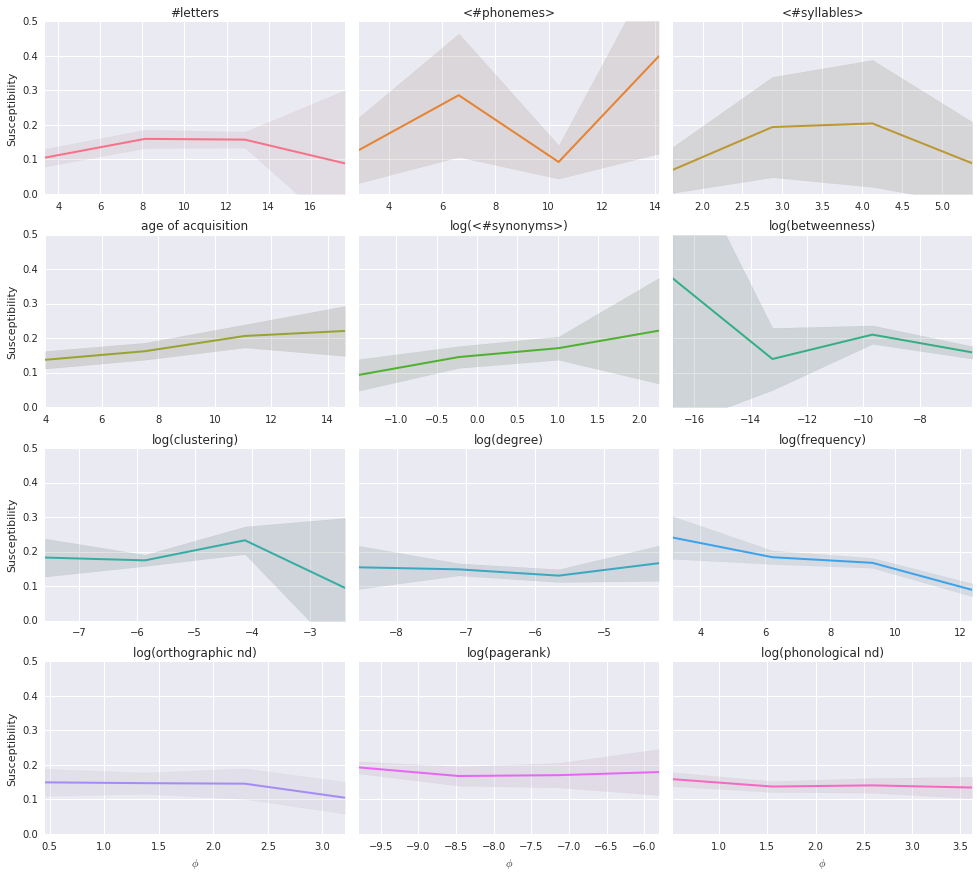

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=susties, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

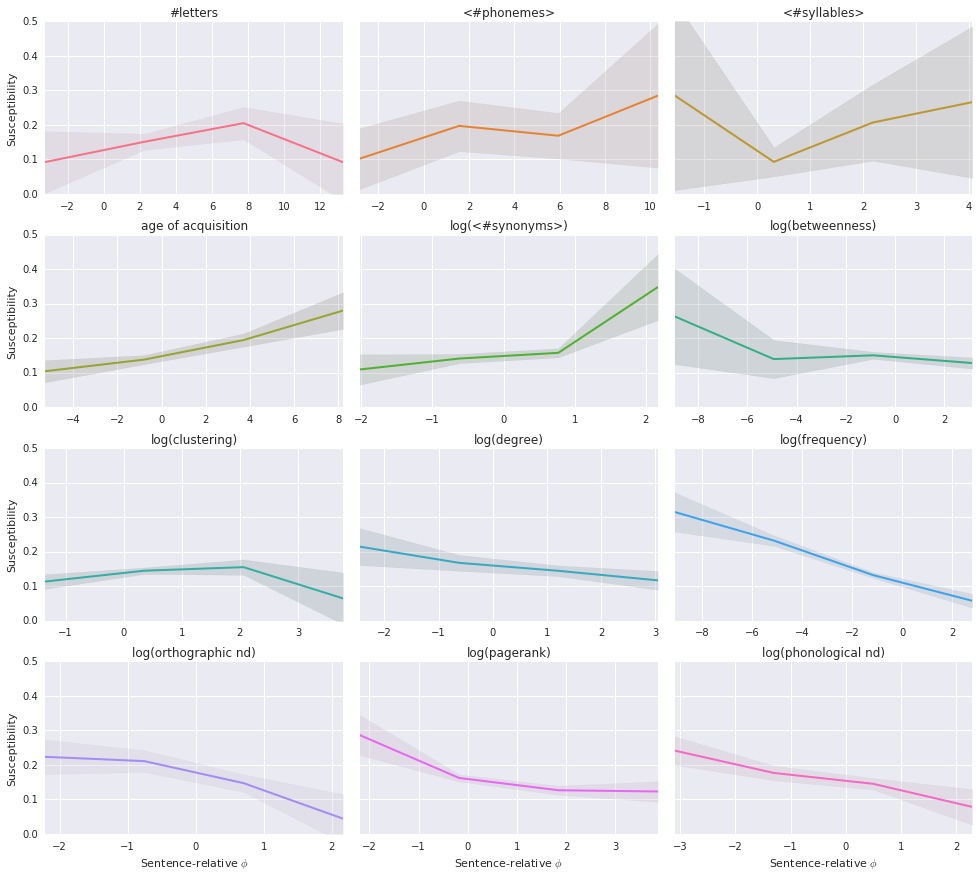

In [8]:
g = sb.FacetGrid(data=susties_rel, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on how confidence intervals are computed here**

There are three ways I can conceive of the computation represented in the graphs above:
1. For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.
2. Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. This is the way CIs are computed above.
3. Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values. So for now I'm sticking with (2).

### 2.2 Feature susceptibilities, reduced to features we expose in the paper

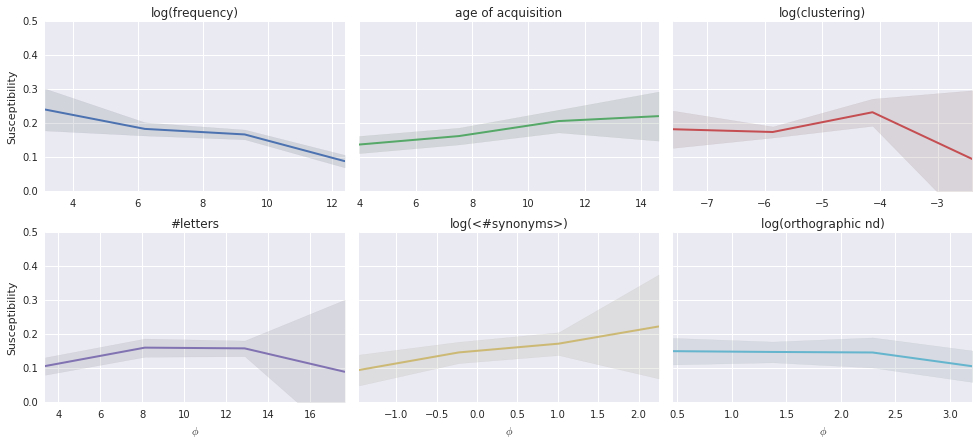

In [9]:
g = sb.FacetGrid(data=susties[susties['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

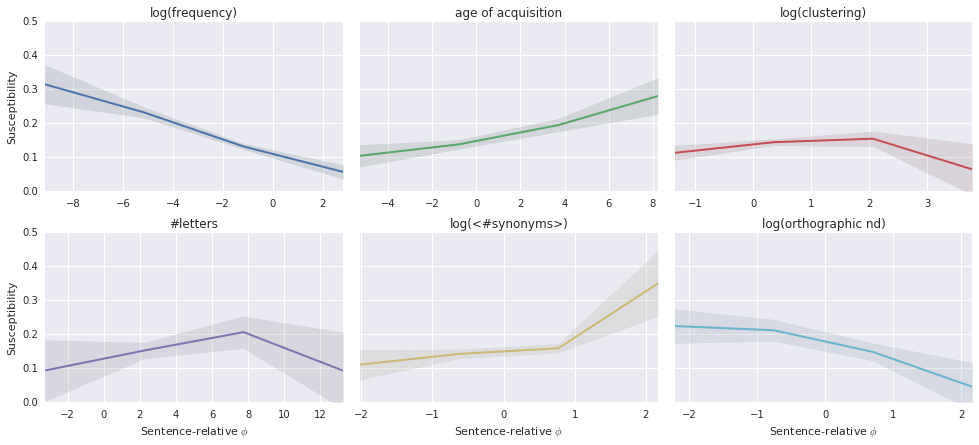

In [10]:
g = sb.FacetGrid(data=susties_rel[susties_rel['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

## 3 On which POS tags do substitutions fall?

In [11]:
poses = susty_words[susty_words.feature == 'aoa'][['POS', 'cluster_id', 'destination_id',
                                                   'occurrence', 'source_id', 'target',
                                                   'weight', 'weight_appeared', 'word']]
# Only take first letter of POS code to denote categories,
# and group stopword-like categories together.
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']
poses['rPOS'] = poses['POS']\
    .apply(lambda x: x[0])\
    .apply(lambda x: 'Stopword-like' if x in stop_poses else x)

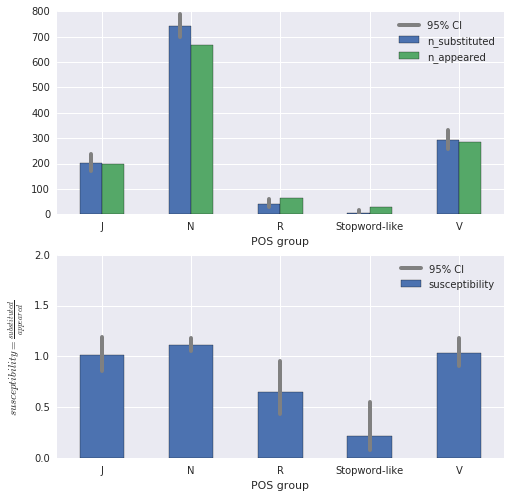

In [12]:
# Compute POS counts.
susty_pos = lambda x: ((x * poses.loc[x.index, 'weight']).sum() /
                       poses.loc[x.index, 'weight_appeared'].sum())
susties_pos = poses.groupby('rPOS')['target'].aggregate(
    {'susceptibility': susty_pos,
     'n_substituted': lambda x: (x * poses.loc[x.index, 'weight']).sum(),
     'n_appeared': lambda x: poses.loc[x.index, 'weight_appeared'].sum()}
).rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']].plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(), method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted, lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility'].plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], cis[i] * total_substituted / susties_pos.n_appeared.iloc[i],
                 lw=4, color='grey', label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-pos_susceptibilities'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [13]:
# Test the n_substituted proportions are different from the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['N', 'R', 'Stopword-like']


## 4 Susceptibility in terms of absolute fractiles

In [14]:
def plot_absolute_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')

    # Compute feature bins.
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_fractiles = pd.qcut(data.value, bin_count, labels=False)
            break
        except ValueError:
            pass

    # Compute bin counts
    heights = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[data.target & (x_fractiles == i)].weight.sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, bin_count + 1), heights, color=color)
    plt.fill_between(range(1, bin_count + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, bin_count + 1))
    plt.xlim(1, bin_count)
    plt.ylim(0, None)

### 4.1 All features susceptibilities

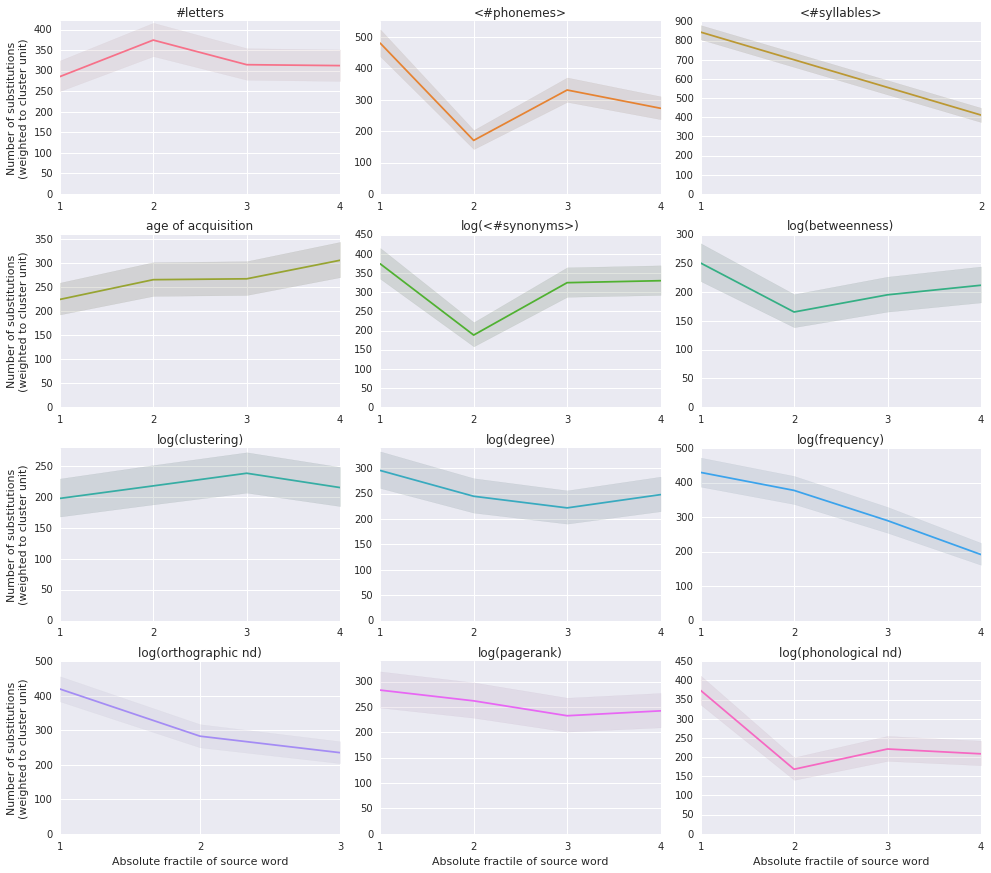

In [15]:
# Now plot.
g = sb.FacetGrid(data=susty_words, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're again in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all absolute feature fractiles are available to sample from in all the sentences. Again, there's no way out of this, so we're going to use multinomial CIs.

### 4.2 Feature susceptibilities, reduced to features we expose in the paper

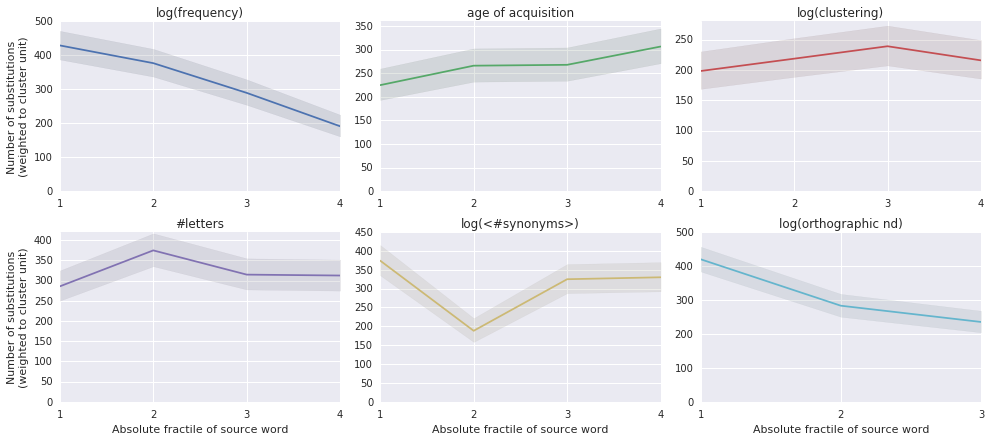

In [16]:
# Now plot.
g = sb.FacetGrid(data=susty_words[susty_words['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

## 5 Susceptibility in terms of sentence fractiles

Build our data.

In [17]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, _ = substitution.features(feature)
            if np.isnan(source):
                # The source word has no feature value. We drop this substitution.
                continue
            sentence, _ = substitution.source_destination_features(feature)
            # Remove stopwords from this analysis, since we dropped substitutions on stopwords.
            dslice = slice(substitution.start,
                           substitution.start + len(substitution.destination.tokens))
            is_stopword = np.array([(lemma in stopwords) or (token in stopwords)
                                    for (lemma, token) in
                                    zip(substitution.source.lemmas[dslice],
                                        substitution.source.tokens[dslice])])
            sentence[is_stopword] = np.nan
            # Find the number of bins we'll use.
            values = set(sentence[np.isfinite(sentence)])
            if len(values) == 0 or len(values) == 1:
                # Only NaNs, or only one feature value. Drop this.
                continue
            start, stop = None, None
            power = 0
            while start is None:
                if int(BIN_COUNT / 2**power) * 2**power != BIN_COUNT:
                    raise ValueError('BIN_COUNT must be a power of 2')
                try:
                    start = 2**power * pd.qcut(sentence, int(BIN_COUNT / 2**power),
                                               labels=False)[substitution.position]
                    stop = start + 2**power
                except ValueError:
                    power += 1
            # And finally save the bin.
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'start': start,
                         'stop': stop})

original_fractiles = pd.DataFrame(data)
del data

  0% (   56 of 11223) |                    | Elapsed Time: 0:00:01 ETA:  0:03:23

  1% (  118 of 11223) |                    | Elapsed Time: 0:00:02 ETA:  0:03:00

  1% (  141 of 11223) |                    | Elapsed Time: 0:00:02 ETA:  0:03:01

  1% (  201 of 11223) |                    | Elapsed Time: 0:00:03 ETA:  0:03:02

  2% (  263 of 11223) |                    | Elapsed Time: 0:00:04 ETA:  0:03:00

  2% (  281 of 11223) |                    | Elapsed Time: 0:00:04 ETA:  0:02:59

  3% (  348 of 11223) |                    | Elapsed Time: 0:00:05 ETA:  0:02:54

  3% (  421 of 11223) |                    | Elapsed Time: 0:00:06 ETA:  0:02:50

  4% (  491 of 11223) |                    | Elapsed Time: 0:00:07 ETA:  0:02:46

  5% (  562 of 11223) |#                   | Elapsed Time: 0:00:08 ETA:  0:02:42

  5% (  635 of 11223) |#                   | Elapsed Time: 0:00:09 ETA:  0:02:36

  6% (  702 of 11223) |#                   | Elapsed Time: 0:00:10 ETA:  0:02:35

  6% (  761 of 11223) |#                   | Elapsed Time: 0:00:11 ETA:  0:02:38

  7% (  817 of 11223) |#                   | Elapsed Time: 0:00:12 ETA:  0:02:43

  7% (  842 of 11223) |#                   | Elapsed Time: 0:00:13 ETA:  0:02:45

  8% (  908 of 11223) |#                   | Elapsed Time: 0:00:14 ETA:  0:02:45

  8% (  968 of 11223) |#                   | Elapsed Time: 0:00:15 ETA:  0:02:47

  8% (  983 of 11223) |#                   | Elapsed Time: 0:00:15 ETA:  0:02:47

  9% ( 1053 of 11223) |#                   | Elapsed Time: 0:00:16 ETA:  0:02:48

  9% ( 1112 of 11223) |#                   | Elapsed Time: 0:00:17 ETA:  0:02:47

 10% ( 1123 of 11223) |##                  | Elapsed Time: 0:00:17 ETA:  0:02:48

 10% ( 1182 of 11223) |##                  | Elapsed Time: 0:00:18 ETA:  0:02:47

 11% ( 1263 of 11223) |##                  | Elapsed Time: 0:00:20 ETA:  0:02:38

 11% ( 1320 of 11223) |##                  | Elapsed Time: 0:00:21 ETA:  0:02:41

 12% ( 1368 of 11223) |##                  | Elapsed Time: 0:00:22 ETA:  0:02:45

 12% ( 1403 of 11223) |##                  | Elapsed Time: 0:00:22 ETA:  0:02:45

 13% ( 1460 of 11223) |##                  | Elapsed Time: 0:00:23 ETA:  0:02:50

 13% ( 1517 of 11223) |##                  | Elapsed Time: 0:00:24 ETA:  0:02:50

 13% ( 1544 of 11223) |##                  | Elapsed Time: 0:00:25 ETA:  0:02:49

 14% ( 1605 of 11223) |##                  | Elapsed Time: 0:00:26 ETA:  0:02:47

 14% ( 1665 of 11223) |##                  | Elapsed Time: 0:00:27 ETA:  0:02:50

 15% ( 1684 of 11223) |###                 | Elapsed Time: 0:00:27 ETA:  0:02:52

 15% ( 1735 of 11223) |###                 | Elapsed Time: 0:00:28 ETA:  0:02:54

 15% ( 1791 of 11223) |###                 | Elapsed Time: 0:00:29 ETA:  0:02:49

 16% ( 1824 of 11223) |###                 | Elapsed Time: 0:00:30 ETA:  0:02:50

 16% ( 1879 of 11223) |###                 | Elapsed Time: 0:00:31 ETA:  0:02:50

 17% ( 1938 of 11223) |###                 | Elapsed Time: 0:00:32 ETA:  0:02:48

 17% ( 1965 of 11223) |###                 | Elapsed Time: 0:00:32 ETA:  0:02:48

 18% ( 2029 of 11223) |###                 | Elapsed Time: 0:00:33 ETA:  0:02:45

 18% ( 2089 of 11223) |###                 | Elapsed Time: 0:00:34 ETA:  0:02:44

 18% ( 2105 of 11223) |###                 | Elapsed Time: 0:00:35 ETA:  0:02:43

 19% ( 2163 of 11223) |###                 | Elapsed Time: 0:00:36 ETA:  0:02:39

 19% ( 2226 of 11223) |###                 | Elapsed Time: 0:00:37 ETA:  0:02:35

 20% ( 2245 of 11223) |####                | Elapsed Time: 0:00:37 ETA:  0:02:31

 20% ( 2307 of 11223) |####                | Elapsed Time: 0:00:38 ETA:  0:02:27

 21% ( 2362 of 11223) |####                | Elapsed Time: 0:00:39 ETA:  0:02:28

 21% ( 2385 of 11223) |####                | Elapsed Time: 0:00:39 ETA:  0:02:28

 21% ( 2445 of 11223) |####                | Elapsed Time: 0:00:40 ETA:  0:02:29

 22% ( 2507 of 11223) |####                | Elapsed Time: 0:00:41 ETA:  0:02:27

 22% ( 2526 of 11223) |####                | Elapsed Time: 0:00:42 ETA:  0:02:25

 23% ( 2589 of 11223) |####                | Elapsed Time: 0:00:43 ETA:  0:02:21

 23% ( 2651 of 11223) |####                | Elapsed Time: 0:00:44 ETA:  0:02:21

 23% ( 2666 of 11223) |####                | Elapsed Time: 0:00:44 ETA:  0:02:23

 24% ( 2718 of 11223) |####                | Elapsed Time: 0:00:45 ETA:  0:02:26

 24% ( 2771 of 11223) |####                | Elapsed Time: 0:00:46 ETA:  0:02:26

 25% ( 2806 of 11223) |#####               | Elapsed Time: 0:00:47 ETA:  0:02:25

 25% ( 2867 of 11223) |#####               | Elapsed Time: 0:00:48 ETA:  0:02:24

 26% ( 2921 of 11223) |#####               | Elapsed Time: 0:00:49 ETA:  0:02:26

 26% ( 2947 of 11223) |#####               | Elapsed Time: 0:00:49 ETA:  0:02:28

 26% ( 3009 of 11223) |#####               | Elapsed Time: 0:00:50 ETA:  0:02:27

 27% ( 3068 of 11223) |#####               | Elapsed Time: 0:00:51 ETA:  0:02:28

 27% ( 3087 of 11223) |#####               | Elapsed Time: 0:00:51 ETA:  0:02:28

 28% ( 3143 of 11223) |#####               | Elapsed Time: 0:00:52 ETA:  0:02:25

 28% ( 3211 of 11223) |#####               | Elapsed Time: 0:00:53 ETA:  0:02:18

 28% ( 3227 of 11223) |#####               | Elapsed Time: 0:00:54 ETA:  0:02:16

 29% ( 3289 of 11223) |#####               | Elapsed Time: 0:00:55 ETA:  0:02:15

 29% ( 3351 of 11223) |#####               | Elapsed Time: 0:00:56 ETA:  0:02:10

 30% ( 3367 of 11223) |######              | Elapsed Time: 0:00:56 ETA:  0:02:10

 30% ( 3427 of 11223) |######              | Elapsed Time: 0:00:57 ETA:  0:02:10

 31% ( 3491 of 11223) |######              | Elapsed Time: 0:00:58 ETA:  0:02:06

 31% ( 3508 of 11223) |######              | Elapsed Time: 0:00:58 ETA:  0:02:05

 31% ( 3564 of 11223) |######              | Elapsed Time: 0:00:59 ETA:  0:02:04

 32% ( 3626 of 11223) |######              | Elapsed Time: 0:01:00 ETA:  0:02:06

 32% ( 3648 of 11223) |######              | Elapsed Time: 0:01:01 ETA:  0:02:04

 32% ( 3702 of 11223) |######              | Elapsed Time: 0:01:02 ETA:  0:02:06

 33% ( 3760 of 11223) |######              | Elapsed Time: 0:01:03 ETA:  0:02:07

 33% ( 3788 of 11223) |######              | Elapsed Time: 0:01:03 ETA:  0:02:05

 34% ( 3852 of 11223) |######              | Elapsed Time: 0:01:04 ETA:  0:02:02

 34% ( 3912 of 11223) |######              | Elapsed Time: 0:01:05 ETA:  0:02:03

 35% ( 3929 of 11223) |#######             | Elapsed Time: 0:01:05 ETA:  0:02:03

 35% ( 3994 of 11223) |#######             | Elapsed Time: 0:01:06 ETA:  0:01:58

 36% ( 4060 of 11223) |#######             | Elapsed Time: 0:01:07 ETA:  0:01:55

 36% ( 4069 of 11223) |#######             | Elapsed Time: 0:01:09 ETA:  0:02:25

 36% ( 4129 of 11223) |#######             | Elapsed Time: 0:01:10 ETA:  0:02:23

 37% ( 4181 of 11223) |#######             | Elapsed Time: 0:01:11 ETA:  0:02:26

 37% ( 4209 of 11223) |#######             | Elapsed Time: 0:01:11 ETA:  0:02:30

 38% ( 4272 of 11223) |#######             | Elapsed Time: 0:01:12 ETA:  0:02:27

 38% ( 4333 of 11223) |#######             | Elapsed Time: 0:01:13 ETA:  0:02:22

 38% ( 4349 of 11223) |#######             | Elapsed Time: 0:01:13 ETA:  0:02:27

 39% ( 4408 of 11223) |#######             | Elapsed Time: 0:01:14 ETA:  0:02:30

 39% ( 4472 of 11223) |#######             | Elapsed Time: 0:01:15 ETA:  0:01:51

 40% ( 4490 of 11223) |########            | Elapsed Time: 0:01:16 ETA:  0:01:50

 40% ( 4556 of 11223) |########            | Elapsed Time: 0:01:17 ETA:  0:01:47

 41% ( 4617 of 11223) |########            | Elapsed Time: 0:01:18 ETA:  0:01:42

 41% ( 4630 of 11223) |########            | Elapsed Time: 0:01:18 ETA:  0:01:42

 41% ( 4693 of 11223) |########            | Elapsed Time: 0:01:19 ETA:  0:01:41

 42% ( 4753 of 11223) |########            | Elapsed Time: 0:01:20 ETA:  0:01:40

 42% ( 4770 of 11223) |########            | Elapsed Time: 0:01:20 ETA:  0:01:42

 43% ( 4827 of 11223) |########            | Elapsed Time: 0:01:21 ETA:  0:01:42

 43% ( 4886 of 11223) |########            | Elapsed Time: 0:01:22 ETA:  0:01:43

 43% ( 4911 of 11223) |########            | Elapsed Time: 0:01:23 ETA:  0:01:40

 44% ( 4978 of 11223) |########            | Elapsed Time: 0:01:24 ETA:  0:01:38

 44% ( 5039 of 11223) |########            | Elapsed Time: 0:01:25 ETA:  0:01:37

 45% ( 5051 of 11223) |#########           | Elapsed Time: 0:01:25 ETA:  0:01:38

 45% ( 5118 of 11223) |#########           | Elapsed Time: 0:01:26 ETA:  0:01:36

 46% ( 5191 of 11223) |#########           | Elapsed Time: 0:01:27 ETA:  0:01:31

 46% ( 5257 of 11223) |#########           | Elapsed Time: 0:01:28 ETA:  0:01:26

 47% ( 5331 of 11223) |#########           | Elapsed Time: 0:01:29 ETA:  0:01:24

 48% ( 5396 of 11223) |#########           | Elapsed Time: 0:01:30 ETA:  0:01:24

 48% ( 5472 of 11223) |#########           | Elapsed Time: 0:01:31 ETA:  0:01:16

 49% ( 5537 of 11223) |#########           | Elapsed Time: 0:01:32 ETA:  0:01:16

 49% ( 5595 of 11223) |#########           | Elapsed Time: 0:01:33 ETA:  0:01:17

 50% ( 5612 of 11223) |##########          | Elapsed Time: 0:01:34 ETA:  0:01:17

 50% ( 5677 of 11223) |##########          | Elapsed Time: 0:01:35 ETA:  0:01:17

 51% ( 5731 of 11223) |##########          | Elapsed Time: 0:01:36 ETA:  0:01:21

 51% ( 5752 of 11223) |##########          | Elapsed Time: 0:01:36 ETA:  0:01:21

 51% ( 5816 of 11223) |##########          | Elapsed Time: 0:01:37 ETA:  0:01:21

 52% ( 5893 of 11223) |##########          | Elapsed Time: 0:01:38 ETA:  0:01:20

 53% ( 5952 of 11223) |##########          | Elapsed Time: 0:01:39 ETA:  0:01:22

 53% ( 6006 of 11223) |##########          | Elapsed Time: 0:01:40 ETA:  0:01:23

 53% ( 6033 of 11223) |##########          | Elapsed Time: 0:01:40 ETA:  0:01:22

 54% ( 6090 of 11223) |##########          | Elapsed Time: 0:01:41 ETA:  0:01:25

 54% ( 6144 of 11223) |##########          | Elapsed Time: 0:01:42 ETA:  0:01:24

 55% ( 6173 of 11223) |###########         | Elapsed Time: 0:01:43 ETA:  0:01:28

 55% ( 6232 of 11223) |###########         | Elapsed Time: 0:01:44 ETA:  0:01:29

 56% ( 6290 of 11223) |###########         | Elapsed Time: 0:01:45 ETA:  0:01:35

 56% ( 6313 of 11223) |###########         | Elapsed Time: 0:01:45 ETA:  0:01:33

 56% ( 6382 of 11223) |###########         | Elapsed Time: 0:01:46 ETA:  0:01:27

 57% ( 6454 of 11223) |###########         | Elapsed Time: 0:01:48 ETA:  0:01:23

 58% ( 6525 of 11223) |###########         | Elapsed Time: 0:01:49 ETA:  0:01:16

 58% ( 6594 of 11223) |###########         | Elapsed Time: 0:01:50 ETA:  0:01:04

 59% ( 6668 of 11223) |###########         | Elapsed Time: 0:01:51 ETA:  0:00:57

 60% ( 6734 of 11223) |############        | Elapsed Time: 0:01:52 ETA:  0:00:57

 60% ( 6796 of 11223) |############        | Elapsed Time: 0:01:53 ETA:  0:00:59

 61% ( 6875 of 11223) |############        | Elapsed Time: 0:01:54 ETA:  0:00:56

 61% ( 6937 of 11223) |############        | Elapsed Time: 0:01:55 ETA:  0:00:58

 62% ( 6994 of 11223) |############        | Elapsed Time: 0:01:56 ETA:  0:01:02

 62% ( 7015 of 11223) |############        | Elapsed Time: 0:01:56 ETA:  0:01:01

 63% ( 7078 of 11223) |############        | Elapsed Time: 0:01:57 ETA:  0:01:05

 63% ( 7139 of 11223) |############        | Elapsed Time: 0:01:58 ETA:  0:01:02

 63% ( 7155 of 11223) |############        | Elapsed Time: 0:01:59 ETA:  0:01:02

 64% ( 7221 of 11223) |############        | Elapsed Time: 0:02:00 ETA:  0:01:00

 64% ( 7282 of 11223) |############        | Elapsed Time: 0:02:01 ETA:  0:01:02

 65% ( 7295 of 11223) |#############       | Elapsed Time: 0:02:01 ETA:  0:01:02

 65% ( 7357 of 11223) |#############       | Elapsed Time: 0:02:02 ETA:  0:01:01

 66% ( 7417 of 11223) |#############       | Elapsed Time: 0:02:03 ETA:  0:00:59

 66% ( 7436 of 11223) |#############       | Elapsed Time: 0:02:03 ETA:  0:00:59

 66% ( 7500 of 11223) |#############       | Elapsed Time: 0:02:04 ETA:  0:00:58

 67% ( 7559 of 11223) |#############       | Elapsed Time: 0:02:05 ETA:  0:00:57

 67% ( 7576 of 11223) |#############       | Elapsed Time: 0:02:06 ETA:  0:00:57

 68% ( 7639 of 11223) |#############       | Elapsed Time: 0:02:07 ETA:  0:00:57

 68% ( 7700 of 11223) |#############       | Elapsed Time: 0:02:08 ETA:  0:00:56

 68% ( 7716 of 11223) |#############       | Elapsed Time: 0:02:08 ETA:  0:00:55

 69% ( 7785 of 11223) |#############       | Elapsed Time: 0:02:09 ETA:  0:00:51

 70% ( 7857 of 11223) |##############      | Elapsed Time: 0:02:10 ETA:  0:00:50

 70% ( 7919 of 11223) |##############      | Elapsed Time: 0:02:11 ETA:  0:00:49

 71% ( 7977 of 11223) |##############      | Elapsed Time: 0:02:12 ETA:  0:00:49

 71% ( 7997 of 11223) |##############      | Elapsed Time: 0:02:12 ETA:  0:00:49

 71% ( 8058 of 11223) |##############      | Elapsed Time: 0:02:13 ETA:  0:00:48

 72% ( 8124 of 11223) |##############      | Elapsed Time: 0:02:14 ETA:  0:00:45

 72% ( 8137 of 11223) |##############      | Elapsed Time: 0:02:15 ETA:  0:00:45

 72% ( 8189 of 11223) |##############      | Elapsed Time: 0:02:16 ETA:  0:00:52

 73% ( 8254 of 11223) |##############      | Elapsed Time: 0:02:17 ETA:  0:00:49

 73% ( 8277 of 11223) |##############      | Elapsed Time: 0:02:17 ETA:  0:00:48

 74% ( 8350 of 11223) |##############      | Elapsed Time: 0:02:18 ETA:  0:00:42

 75% ( 8418 of 11223) |###############     | Elapsed Time: 0:02:19 ETA:  0:00:35

 75% ( 8485 of 11223) |###############     | Elapsed Time: 0:02:20 ETA:  0:00:32

 76% ( 8540 of 11223) |###############     | Elapsed Time: 0:02:21 ETA:  0:00:33

 76% ( 8558 of 11223) |###############     | Elapsed Time: 0:02:21 ETA:  0:00:35

 76% ( 8626 of 11223) |###############     | Elapsed Time: 0:02:22 ETA:  0:00:33

 77% ( 8684 of 11223) |###############     | Elapsed Time: 0:02:23 ETA:  0:00:30

 77% ( 8698 of 11223) |###############     | Elapsed Time: 0:02:23 ETA:  0:00:30

 78% ( 8754 of 11223) |###############     | Elapsed Time: 0:02:24 ETA:  0:00:32

 78% ( 8808 of 11223) |###############     | Elapsed Time: 0:02:25 ETA:  0:00:39

 78% ( 8839 of 11223) |###############     | Elapsed Time: 0:02:26 ETA:  0:00:42

 79% ( 8902 of 11223) |###############     | Elapsed Time: 0:02:27 ETA:  0:00:43

 80% ( 8979 of 11223) |################    | Elapsed Time: 0:02:28 ETA:  0:00:34

 80% ( 9046 of 11223) |################    | Elapsed Time: 0:02:29 ETA:  0:00:34

 81% ( 9119 of 11223) |################    | Elapsed Time: 0:02:30 ETA:  0:00:29

 81% ( 9185 of 11223) |################    | Elapsed Time: 0:02:31 ETA:  0:00:24

 82% ( 9259 of 11223) |################    | Elapsed Time: 0:02:32 ETA:  0:00:19

 83% ( 9322 of 11223) |################    | Elapsed Time: 0:02:33 ETA:  0:00:18

 83% ( 9400 of 11223) |################    | Elapsed Time: 0:02:34 ETA:  0:00:15

 84% ( 9468 of 11223) |################    | Elapsed Time: 0:02:35 ETA:  0:00:14

 85% ( 9540 of 11223) |#################   | Elapsed Time: 0:02:37 ETA:  0:00:11

 85% ( 9600 of 11223) |#################   | Elapsed Time: 0:02:38 ETA:  0:00:13

 86% ( 9680 of 11223) |#################   | Elapsed Time: 0:02:39 ETA:  0:00:10

 86% ( 9742 of 11223) |#################   | Elapsed Time: 0:02:40 ETA:  0:00:09

 87% ( 9808 of 11223) |#################   | Elapsed Time: 0:02:41 ETA:  0:00:11

 87% ( 9821 of 11223) |#################   | Elapsed Time: 0:02:41 ETA:  0:00:12

 88% ( 9888 of 11223) |#################   | Elapsed Time: 0:02:42 ETA:  0:00:12

 88% ( 9961 of 11223) |#################   | Elapsed Time: 0:02:43 ETA:  0:00:12

 89% (10030 of 11223) |#################   | Elapsed Time: 0:02:44 ETA:  0:00:07

 90% (10101 of 11223) |##################  | Elapsed Time: 0:02:45 ETA:  0:00:09

 90% (10167 of 11223) |##################  | Elapsed Time: 0:02:46 ETA:  0:00:06

 91% (10241 of 11223) |##################  | Elapsed Time: 0:02:47 ETA:  0:00:04

 91% (10305 of 11223) |##################  | Elapsed Time: 0:02:48 ETA:  0:00:04

 92% (10382 of 11223) |##################  | Elapsed Time: 0:02:50 ETA:  0:00:02

 93% (10453 of 11223) |##################  | Elapsed Time: 0:02:51 ETA:  0:00:00

 93% (10522 of 11223) |##################  | Elapsed Time: 0:02:52 ETA:  0:00:00

 94% (10584 of 11223) |##################  | Elapsed Time: 0:02:53 ETA:  0:00:00

 94% (10600 of 11223) |##################  | Elapsed Time: 0:02:54 ETA:  0:00:37

 95% (10662 of 11223) |################### | Elapsed Time: 0:02:55 ETA:  0:00:43

 95% (10718 of 11223) |################### | Elapsed Time: 0:02:57 ETA:  0:00:50

 96% (10784 of 11223) |################### | Elapsed Time: 0:02:58 ETA:  0:00:41

 96% (10803 of 11223) |################### | Elapsed Time: 0:02:58 ETA:  0:00:51

 96% (10869 of 11223) |################### | Elapsed Time: 0:02:59 ETA:  0:00:49

 97% (10943 of 11223) |################### | Elapsed Time: 0:03:00 ETA:  0:00:46

 98% (11004 of 11223) |################### | Elapsed Time: 0:03:01 ETA:  0:00:03

 98% (11062 of 11223) |################### | Elapsed Time: 0:03:02 ETA:  0:00:01

 98% (11083 of 11223) |################### | Elapsed Time: 0:03:02 ETA:  0:00:01

 99% (11145 of 11223) |################### | Elapsed Time: 0:03:03 ETA:  0:00:00

100% (11223 of 11223) |####################| Elapsed Time: 0:03:05 Time: 0:03:05


Compute the weight of each substitution, according to what other substitutions it's pooled with, and the size of its bin. Letting:
* $n_d(i) = \#\text{substitutions with same durl as substitution }i$
* and $n_c(i) = \#\text{substitutions with same cluster as substitution }i$ (counting substitutions with the same durl as one)
* $p(i) = \text{precision (width) of the bin we assigned to substitution }i$

Then we define the weight of a substitution $i$:
$$w(i) = \frac{1}{n_d(i) n_c(i) p(i)}$$

In [18]:
fractiles = original_fractiles.copy()
divide_sum = lambda x: x / x.sum()

# Weight is 1 at first.
fractiles['weight'] = 1
# Divided by the number of substitutions that share a durl.
fractiles['weight'] = fractiles\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
fractiles['weight'] = fractiles\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_sum)
# And finally divide by the precision of the bin we put a substitution in.
fractiles['weight'] = fractiles['weight'] / (fractiles['stop'] - fractiles['start'])

Now for each feature, count the sum of weights in each bin and plot that.

In [19]:
def plot_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = data[(data['start'] <= i) & (i < data['stop'])]['weight'].sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, BIN_COUNT + 1), heights, color=color)
    plt.fill_between(range(1, BIN_COUNT + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, BIN_COUNT + 1))
    plt.ylim(0, None)

### 5.1 All features susceptibilities

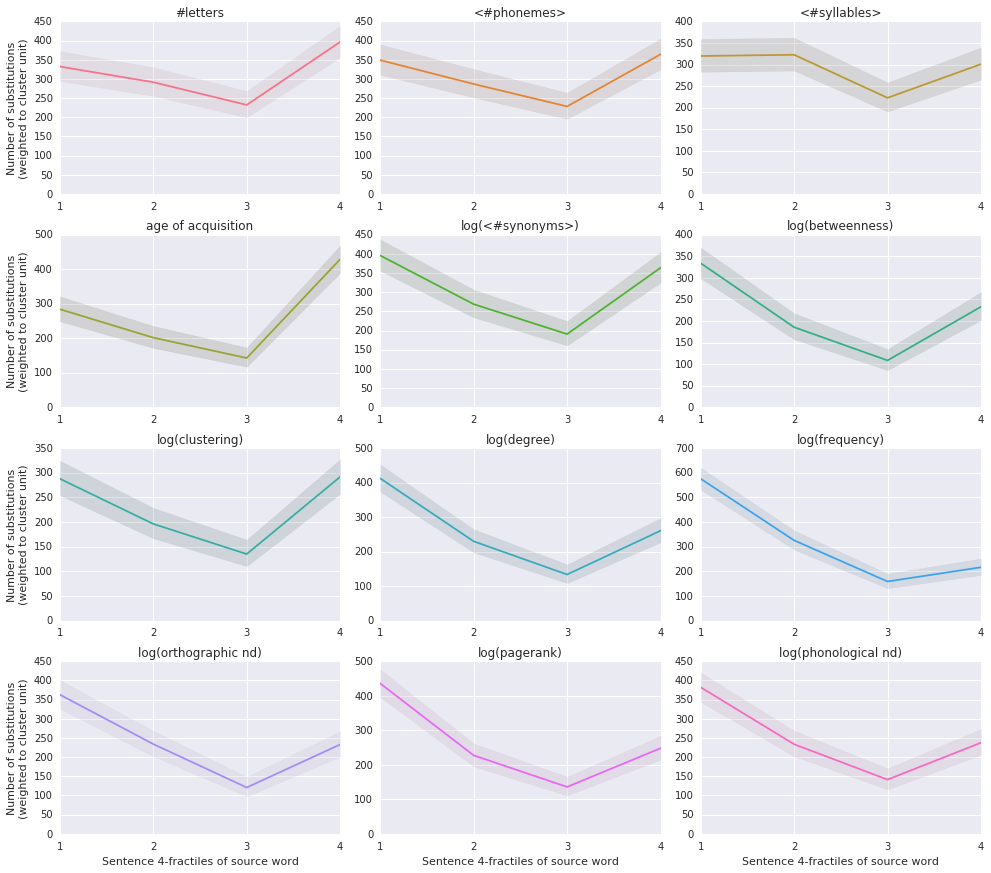

In [20]:
# Now plot.
g = sb.FacetGrid(data=fractiles, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're finally in a real multinomial sampling (and it's the only time). So we're going to use multinomial CIs.

### 5.2 Feature susceptibilities, reduced to features we expose in the paper

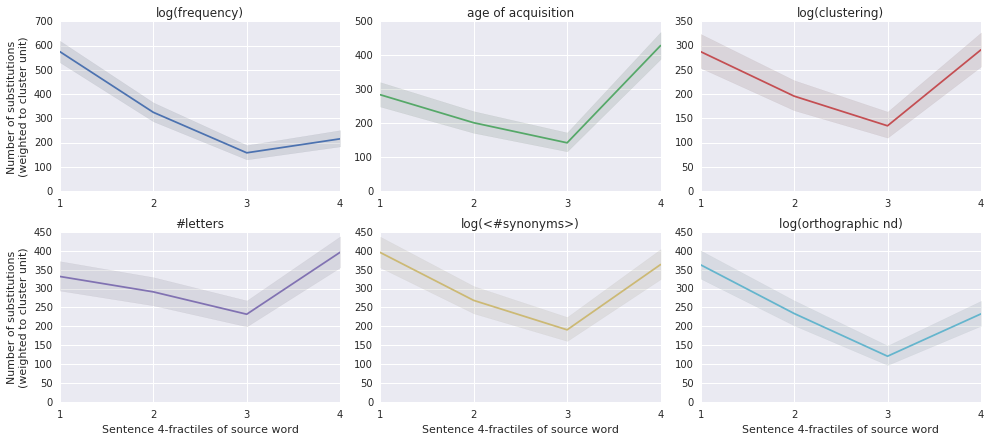

In [21]:
# Now plot.
g = sb.FacetGrid(data=fractiles[fractiles['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)